#### Import

In [1]:
import json
import pickle
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

#### Use Target file

In [7]:
with open("pickles/TARGET-communities-extract-wellbeing.pkl", "rb") as handler:
    target = pickle.load(handler)
df_target = pd.DataFrame(columns=target[0], data=target[1:])
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
0,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287016932,31.1558823799679
1,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529089795,31.144326843509
2,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520387505,31.0422853979528
3,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237458941,31.2407251034807
4,万里名轩社区居委会,2,,0.0,万里街道,普陀区,121.403601417271,31.269155049366


#### Clean Target file

In [8]:
# Delete rows which don't have the 3 target values
df_target = df_target[(df_target['clean'] != '') & (df_target['smell'] != '') & (df_target['noise'] != '')]
# Delete rows which don't have coordinates
df_target = df_target[(df_target['longitude'] != '') & (df_target['latitude'] != '')]

# Change the data type of the targets (string to float)
df_target['clean'] = df_target['clean'].apply(lambda x: float(x))
df_target['smell'] = df_target['smell'].apply(lambda x: float(x))
df_target['noise'] = df_target['noise'].apply(lambda x: float(x))
df_target['longitude'] = df_target['longitude'].apply(lambda x: float(x))
df_target['latitude'] = df_target['latitude'].apply(lambda x: float(x))

# Substract 1 to clean values --> Put the lowest clean score to 0 instead of 1 
df_target['clean'] = df_target['clean'].apply(lambda x: x-1)

#### Add geometry points to the df

In [11]:
geometry = [Point(xy) for xy in zip(df_target['longitude'], df_target['latitude'])]
df_target['geometry'] = geometry

### ----------------------------------------------------------------------------------------------------------

#### Use Neighborhood file

In [14]:
# Get Shanghai neighborhood data
df_neigh = pd.read_pickle("pickles/utseus-cendus-shanghai-neighborhoods.pk")

In [ ]:
df_neigh['ID'] = ''
for i, row in df_neigh.iterrows():
    df_neigh['ID'][i] = i

#### Add the neighborhood to the corresponding target points

In [16]:
df_target['neighborhood'] = ''
# Get the number of target in each neighborhood
for i, target in df_target.iterrows():
    find = False
    for j, neigh in df_neigh.iterrows():
        if(target['geometry'].within(neigh['geometry'])):
            df_target['neighborhood'][i] = j
            find = True
        if find:
            break

#### Add the number of targets in each neighbohood

In [17]:
df_neigh['nb_target'] = 0
for i, target in df_target.iterrows():
    find = False
    for j, neigh in df_neigh.iterrows():
        if(target['geometry'].within(neigh['geometry'])):
            df_neigh['nb_target'][j] = df_neigh['nb_target'][j]+1
            find = True
        if find:
            break

#### Keep only the neighborhood where there is at least 1 target

In [10]:
df_neigh_ml = df_neigh[df_neigh['nb_target'] > 0]

#### Calculate the surface per neighborhoods (km2)

In [3]:
df_neigh_ml['surface'] = 0.0

In [ ]:
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial

# 4326 ou 4479
for i, neigh in df_neigh_ml.iterrows():
    geom = neigh['geometry']
    geom_area = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat_1=geom.bounds[1],
                lat_2=geom.bounds[3])),
                geom)
    # Add the surface of the area (km2)
    df_neigh_ml['surface'][neigh['ID']] = float(geom_area.area/1000000)

### ----------------------------------------------------------------------------------------------------------

#### Use Cendus POI file

In [5]:
df_poi = pd.read_pickle("pickles/utseus-cendus-poi.pk")
df_poi.head()

,NAME,GPSX,GPSY,GBCODE,category,subcategory,subsubcategory
0,2015年中国国际纱线(春夏)展览会,121.296368,31.188324,990000.0,Other points of interest,Natural Place Name Identification Points,Entrance name
1,勃兰登堡之声-2015家庭音乐会,121.473360,31.228923,990000.0,Other points of interest,Natural Place Name Identification Points,Entrance name
2,2015第十四届(上海)国际有机食品和绿色食品博览会,121.399378,31.205028,990000.0,Other points of interest,Natural Place Name Identification Points,Entrance name
3,星星火炬上海组委会,121.529628,31.271063,990000.0,Other points of interest,Natural Place Name Identification Points,Entrance name
4,2016VGT国际铁人三项赛,121.169185,31.282332,990000.0,Other points of interest,Natural Place Name Identification Points,Entrance name


#### Add geometry SHOP POI category points to the df

In [7]:
shop_cat = ['Vehicle Sales Shop', 'Supermarket Convenience Store', 'Market', 'Home Building Materials Retail Shop',
            'Clothing, shoes and leather retail store', 'Food-beverage and tobacco products retail stores', 
            'Integrated market', 'Characteristic Commercial Street', 'Flower, Bird, Insect and Fish Market']

df_shop = df_poi[df_poi.subcategory.isin(shop_cat)]

geometry = [Point(xy) for xy in zip(df_shop['GPSX'], df_shop['GPSY'])]
df_shop['geometry'] = geometry

len(df_shop)

D:\Programmes\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


190933

#### Add geometry RESTAURANT POI category points to the df

In [8]:
df_rest = df_poi[df_poi['category'] == "Restaurant"]

geometry = [Point(xy) for xy in zip(df_rest['GPSX'], df_rest['GPSY'])]
df_rest['geometry'] = geometry

len(df_rest)

D:\Programmes\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


227785

#### Add geometry ENTERTAINEMENT POI category points to the df

In [9]:
entert_cat = ['Stadium and Gymnasium', 'Movie theater', 'Sports and leisure']
entert_subcat = ['Song and dance hall/nightclub', 'Game Hall/Video City', 'Entertainment place', 'KTV', 'Bar']
df_entert = df_poi[df_poi.subcategory.isin(entert_cat) | df_poi.subsubcategory.isin(entert_subcat)]
geometry = [Point(xy) for xy in zip(df_entert['GPSX'], df_entert['GPSY'])]
df_entert['geometry'] = geometry
len(df_entert)

D:\Programmes\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


14137

#### Add TRANSPORT POI total number to neighborhoods

In [8]:
df_neigh_ml.loc[:,'nb_transp'] = 0

In [ ]:
for j, poi in df_transp.iterrows():
    find = False
    for i, neigh in df_neigh_ml.iterrows():
        if poi['geometry'].within(neigh['geometry']):
            df_neigh_ml['nb_transp'][neigh['ID']] += 1
            find = True
        if find:
            break

#### Add RESTAURANT POI total number to neighborhoods

In [10]:
df_neigh_ml['nb_rest'] = 0

In [ ]:
for j, poi in df_rest.iterrows():
    find = False
    for i, neigh in df_neigh_ml.iterrows():
        if poi['geometry'].within(neigh['geometry']):
            df_neigh_ml['nb_rest'][neigh['ID']] += 1
            find = True
        if find:
            break

#### Add SHOP POI total number to neighborhoods

In [12]:
df_neigh_ml['nb_shop'] = 0

In [ ]:
for j, poi in df_shop.iterrows():
    find = False
    for i, neigh in df_neigh_ml.iterrows():
        if poi['geometry'].within(neigh['geometry']):
            df_neigh_ml['nb_shop'][neigh['ID']] += 1
            find = True
        if find:
            break

#### Add ENTERTAINEMENT POI total number to neighborhoods

In [15]:
df_neigh_ml['nb_entertainement'] = 0

In [ ]:
for j, poi in df_entert.iterrows():
    find = False
    for i, neigh in df_neigh_ml.iterrows():
        if poi['geometry'].within(neigh['geometry']):
            df_neigh_ml['nb_entertainement'][neigh['ID']] += 1
            find = True
        if find:
            break

### --------------------------------------------------------------------------------------------------------

#### Use Taxi file

In [16]:
df_taxi = pd.read_pickle("pickles/utseus-shanghai-taxi-speed-position.pk")
print(len(df_taxi))
df_taxi.head()

1528047


,taxi_id,time,status,lon,lat,speed,geometry
0,24029,2015-04-11,0,121.421822,31.212080,19.6,POINT (121.42653 31.21023)
1,24029,2015-04-11,0,121.423275,31.212148,15.8,POINT (121.42798 31.21029)
2,24029,2015-04-11,0,121.424295,31.212597,11.5,POINT (121.42900 31.21074)
3,24029,2015-04-11,0,121.426872,31.215222,6.5,POINT (121.43157 31.21337)
4,24029,2015-04-11,0,121.427138,31.215365,6.7,POINT (121.43184 31.21351)


In [17]:
taxi_list = []
df_neigh_ml['nb_taxi'] = 0

#### Add a unique taxi in its neighbohood

In [43]:
for nb in df_taxi.taxi_id.unique():
    if nb in taxi_list:
        continue
    find = False
    for i, neigh in df_neigh_ml.iterrows():
        if(df_taxi[df_taxi['taxi_id'] == nb]['geometry'].iloc[0].within(neigh['geometry'])):
            df_neigh_ml['nb_taxi'][neigh['ID']] += 1
            find = True
        if find:
            taxi_list.append(nb)
            break

### --------------------------------------------------------------------------------------------------------

#### Calculate the number of all POI/Taxi per km inside each neighborhood

In [25]:
df_neigh_ml['nb_taxi_km'] = df_neigh_ml['nb_taxi']/df_neigh_ml['surface']
df_neigh_ml['nb_transp_km'] = df_neigh_ml['nb_transp']/df_neigh_ml['surface']
df_neigh_ml['nb_shop_km'] = df_neigh_ml['nb_shop']/df_neigh_ml['surface']
df_neigh_ml['nb_rest_km'] = df_neigh_ml['nb_rest']/df_neigh_ml['surface']
df_neigh_ml['nb_entertainement_km'] = df_neigh_ml['nb_entertainement']/df_neigh_ml['surface']

### --------------------------------------------------------------------------------------------------------

In [22]:
import pickle
with open('df_neighborhood.pkl', 'wb') as handle:
    pickle.dump(df_neigh_ml, handle)
with open('df_target.pkl', 'wb') as handle:
    pickle.dump(df_target, handle)

In [15]:
import pickle
with open('df_neighborhood.pkl', 'rb') as handle:
    df_neigh_ml = pickle.load(handle)
with open('df_target.pkl', 'rb') as handle:
    df_target = pickle.load(handle)

#### Find the targets mean in each neighborhood

In [27]:
df_neigh_ml['smell_mean'] = df_neigh_ml['ID'].apply(lambda x: df_target[df_target['neighborhood'] == x]['smell'].mean())
df_neigh_ml['noise_mean'] = df_neigh_ml['ID'].apply(lambda x: df_target[df_target['neighborhood'] == x]['noise'].mean())
df_neigh_ml['clean_mean'] = df_neigh_ml['ID'].apply(lambda x: df_target[df_target['neighborhood'] == x]['clean'].mean())

#### Create target classes depending on the mean value in each neighborhood

In [27]:
df_neigh_ml['clean_cat'] = df_neigh_ml['clean_mean'].apply(lambda x:"Very dirty" if x < 0.75 else 
                                                                    "Dirty" if (x >= 0.75 and x < 1.5) else
                                                                    "Clean" if (x >= 1.5 and x < 2.25) else
                                                                    "Very clean")

df_neigh_ml['smell_cat'] = df_neigh_ml['smell_mean'].apply(lambda x: "Smelly" if x >= 0.5 else "Not smelly")

df_neigh_ml['noise_cat'] = df_neigh_ml['noise_mean'].apply(lambda x: "Noisy" if x >= 0.5 else "Not noisy")

df_neigh_ml.head(1)

,NAME,TYPE,geometry,ID,nb_target,happiness,nb_taxi,surface,nb_transp,nb_rest,...,noise_mean,clean_mean,clean_cat,smell_cat,noise_cat,nb_taxi_km,nb_transp_km,nb_shop_km,nb_rest_km,nb_entertainement_km
5,???,2,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",5,1,89.166667,3,43.863191,1622,1131,...,0.0,2.0,Clean,Not smelly,Not noisy,0.068394,36.978614,26.582653,25.784718,1.36789


#### Tried to see the trend lines

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
sns.set()

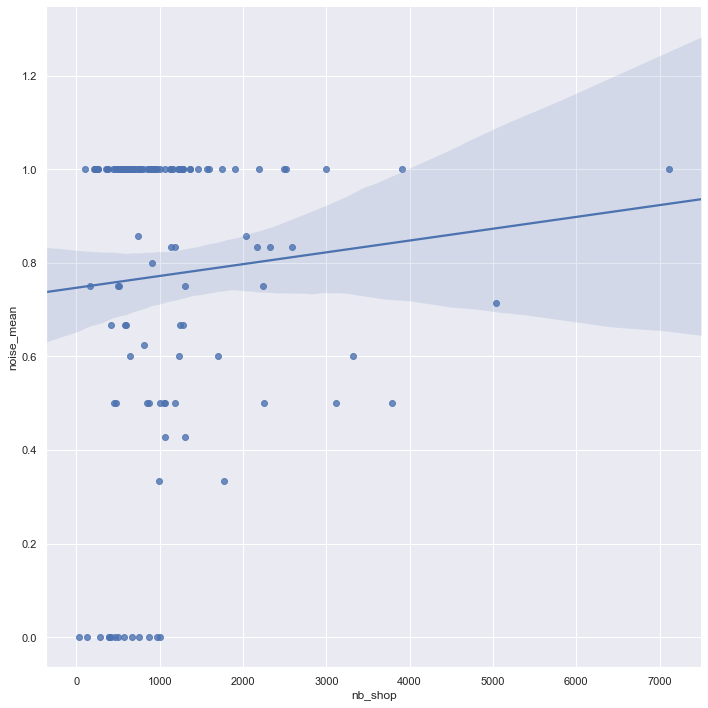

In [15]:
sns.lmplot(x='nb_shop', y='noise_mean', data=df_neigh_ml, height=10)
#plt.yscale('log')
#plt.xscale('log')

### ----------------------------------------------------------------------------------------------------

#### Use Real Estate file  --- Average meter_square_price for each neighborhood --- Not used in ML

In [6]:
with open('pickles/utseus-anjuke-real-estate.pk', 'rb') as handle:
    real_estate = pickle.load(handle)

In [7]:
df_real_estate = pd.DataFrame(columns=real_estate[0], data=real_estate[1:])
df_real_estate.head()

,id,address,longitude,latitude,bedroom,room,surface,price,onesquaremeter,tags,district,neighborhood,done
0,A888553302,宝山-大场 金地艺境(宝山)(555弄),121.34392735101,31.3193561718426,2,2,30.0,1160000.0,38666.6666666667,金地开发 **首推 地铁首通 价格首降 配套就是你能想到的,baoshan,dachang,1
1,A888376847,宝山-大场 骏华苑,121.407324884273,31.3023675431043,1,1,38.0,1950000.0,51315.7894736842,龙璟公馆嘉兴市近万达广场，北大附属实验校区，地铁沿线高铁站旁,baoshan,dachang,1
2,A885088482,宝山-大场 琉樽尚品(255弄),121.397487377268,31.2908711986862,3,2,92.0,5350000.0,58152.1739130435,92+7平书房，婚房装修30万！满2年税少11万！再降20万,baoshan,dachang,1
3,A885392981,宝山-大场 琉樽尚品（255弄）,121.397487377268,31.2908711986862,2,2,68.0,4350000.0,63970.5882352941,中环景观，电梯复式，豪装45万全送，拎包入住，小格局大设计，,baoshan,dachang,1
4,A885831305,宝山-大场 美好家小区,121.421397234518,31.302658471085,2,2,80.0,4000000.0,50000.0,美好家南北通精装2房板式房型采光好随时好看带天井,baoshan,dachang,1


In [ ]:
df_real_estate = df_real_estate[(df_real_estate['longitude'] != '') & (df_real_estate['latitude'] != '')]
df_real_estate['longitude'] = df_real_estate['longitude'].apply(lambda x: float(x))
df_real_estate['latitude'] = df_real_estate['latitude'].apply(lambda x: float(x))

In [13]:
geometry = [Point(xy) for xy in zip(df_real_estate['longitude'], df_real_estate['latitude'])]
df_real_estate['geometry'] = geometry

In [16]:
df_neigh_ml['nb_real_estate'] = 0
df_neigh_ml['priceonesquare'] = 0.0

In [ ]:
for j, poi in df_real_estate.iterrows():
    find = False
    for i, neigh in df_neigh_ml.iterrows():
        if poi['geometry'].within(neigh['geometry']):
            df_neigh_ml['nb_real_estate'][neigh['ID']] += 1
            df_neigh_ml['priceonesquare'][neigh['ID']] += float(poi['onesquaremeter'])
            find = True
        if find:
            break

In [20]:
df_neigh_ml['re_price_avg'] = df_neigh_ml['priceonesquare']/df_neigh_ml['nb_real_estate']

In [21]:
df_neigh_ml.head()

,NAME,TYPE,geometry,ID,nb_target,happiness,nb_taxi,surface,nb_transp,nb_rest,...,smell_cat,noise_cat,nb_taxi_km,nb_transp_km,nb_shop_km,nb_rest_km,nb_entertainement_km,nb_real_estate,priceonesquare,re_price_avg
5,???,2,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",5,1,89.166667,3,43.863191,1622,1131,...,Not smelly,Not noisy,0.068394,36.978614,26.582653,25.784718,1.367890,2289,5.317324e+07,23229.898809
7,???,2,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",7,2,83.750000,0,34.930480,835,177,...,Not smelly,Not noisy,0.000000,23.904625,6.784905,5.067208,0.286283,6,6.292617e+04,10487.694636
8,???,2,"POLYGON Z ((121.36713 30.84311 0.00000, 121.36...",8,2,89.166667,0,58.785377,767,157,...,Not smelly,Not noisy,0.000000,13.047462,3.708405,2.670732,0.068044,432,4.131640e+06,9563.982500
10,???,2,"POLYGON Z ((121.76851 30.88156 0.00000, 121.76...",10,1,78.333333,2,105.243132,1267,1030,...,Not smelly,Not noisy,0.019004,12.038790,2.460968,9.786862,0.589112,5117,1.022295e+08,19978.405717
11,???,2,"POLYGON Z ((121.50531 30.88954 0.00000, 121.50...",11,1,45.833333,2,95.484156,1235,398,...,Not smelly,Noisy,0.020946,12.934083,4.147285,4.168231,0.230405,2377,4.245129e+07,17859.186020
